## Construct Predictive Model and Infer Response
Here we construct large bayes model to predict the associations between mutations and phenotype

In [1]:
import numpy 
import plotly as py
import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
import numpy as np
import random as random
np.random.seed(7678)
from sklearn.metrics import auc, roc_curve

import sys
sys.path.insert(0, '../MutCat/')
import ccal # Original repository is in https://github.com/UCSD-CCAL/ccal

import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

py.offline.init_notebook_mode(connected=True)

from ancillary_v1_0 import *

from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

CCAL version 0.9.2 @ /home/ebc/variome/GIT/MutCat/MutCat/ccal/__init__.py


In [2]:
NRF2_RNA = pd.read_table('/home/ebc/variome/GIT/omphalos/analysis/NRF2_pathway/dataframes/step3/CCLE_NRF2_target.gct', header=None)
NRF2_RNA.rename(columns={0:'Tumor_Sample_Barcode',1:'RNA_signature'},inplace=True)
NRF2_RNA.set_index('Tumor_Sample_Barcode', inplace=True)


In [3]:
pathway = 'NRF2'
input_file_name = '/home/ebc/variome/GIT/omphalos/analysis/NRF2_pathway/dataframes/step3/mutations_NRF2v2_step3.csv' # clusters of mutations

path = '/home/ebc/variome/GIT/omphalos/analysis/NRF2_pathway/dataframes/step4/'

df = pd.read_csv(input_file_name,index_col=0)
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True)

RNA_signature_file = '/home/ebc/variome/GIT/omphalos/data/GSEA/CCLE_expression_full.reformatted.NRF2_signature.gct'
rna = pd.read_table(RNA_signature_file, header=0, sep='\t', skiprows=2)
rna.rename(columns={0:'Tumor_Sample_Barcode',1:'RNA_signature'},inplace=True)
target = rna.iloc[0,2:]
target = (target - target.mean())/(target.std())

target.to_csv(path+'/CCLE_{}_target.gct'.format(pathway), sep='\t')


## Split Data into Test / Train sets

In [4]:
path_test_train = '/home/ebc/variome/GIT/omphalos/analysis/NRF2_pathway/dataframes/step4/test_train_sets/'

target_data = df[['Tumor_Sample_Barcode','R']].drop_duplicates()

output_name_1 = 'split_target_data'

for i in range(20):
    msk = np.random.rand(len(target_data)) < 0.8
    train = target_data[msk]
    test = target_data[~msk]
    
    #save 
    train.to_csv(path_test_train+output_name_1+'_train_%s.csv'%(str(i)))
    test.to_csv(path_test_train+output_name_1+'_test_%s.csv'%(str(i)))

## Feature selection - most predictable clusters

#### Reformulate data

In [5]:
df['cluster_ID'] = [str(df.loc[i,'ID'])+'_'+str(df.loc[i,'cluster_grp']) for i in df.index]
df[['Tumor_Sample_Barcode','cluster_ID']].head(2)

,Tumor_Sample_Barcode,cluster_ID
0,OC316_OVARY,UCHL1_3KW5.A_a
1,OC314_OVARY,UCHL1_3KW5.A_a


In [6]:
cell_list = df.Tumor_Sample_Barcode.unique().tolist()

cluster_components = pd.DataFrame(columns=cell_list)

cluster_list = df.cluster_ID.unique().tolist()


for i in cluster_list:
    
    binary_list = []
    
    tmp = df[df.cluster_ID==i].Tumor_Sample_Barcode.unique().tolist()
    
    for j in cluster_components.columns:
        if j in tmp:
            binary_list.append(1)
        else:
            binary_list.append(0)
            
    cluster_components.at[i] = binary_list

#cluster_components = cluster_components.apply(pd.to_numeric)
cluster_components.head(2)    

,OC316_OVARY,OC314_OVARY,LP1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,HCC2998_LARGE_INTESTINE,HCT15_LARGE_INTESTINE,IM9_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,SW403_LARGE_INTESTINE,HPAC_PANCREAS,SNU1040_LARGE_INTESTINE,MCC26_SKIN,OCILY12_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NCIH2172_LUNG,LXF289_LUNG,MCF7_BREAST,KPL1_BREAST,LU135_LUNG,TMK1_STOMACH,HCC15_LUNG,NCIH1648_LUNG,DMS454_LUNG,RMUGS_OVARY,NCIH647_LUNG,T3M10_LUNG,LS411N_LARGE_INTESTINE,OAW28_OVARY,HPBALL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,SF172_CENTRAL_NERVOUS_SYSTEM,NCIH1339_LUNG,NCIH1435_LUNG,MOLT3_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,JHU028_LUNG,A549_LUNG,SNU423_LIVER,NCIH1688_LUNG,HEC265_ENDOMETRIUM,JHOC5_OVARY,MPP89_PLEURA,NCIH2110_LUNG,BEN_LUNG,HEC108_ENDOMETRIUM,HCC2935_LUNG,HUH1_LIVER,HEC1_ENDOMETRIUM,MOLT4_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,SNU175_LARGE_INTESTINE,NCIH1792_LUNG,CMLT1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,KCL22_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NCIH2030_LUNG,NCIH1755_LUNG,RKO_LARGE_INTESTINE,NCIH740_LUNG,SUPHD1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NB6_AUTONOMIC_GANGLIA,NCIH322_LUNG,P30OHK_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,UMC11_LUNG,SKGT2_STOMACH,BC3C_URINARY_TRACT,TK_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,HUH7_LIVER,NALM6_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ETK1_BILIARY_TRACT,KON_UPPER_AERODIGESTIVE_TRACT,HO1U1_UPPER_AERODIGESTIVE_TRACT,NCIH838_LUNG,NCIH2066_LUNG,NCIH2170_LUNG,JK1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,IOMMLEE_CENTRAL_NERVOUS_SYSTEM,JHH5_LIVER,CAKI2_KIDNEY,SNUC4_LARGE_INTESTINE,HSC2_UPPER_AERODIGESTIVE_TRACT,MFE319_ENDOMETRIUM,SNU308_BILIARY_TRACT,SNU475_LIVER,RL952_ENDOMETRIUM,SCC9_UPPER_AERODIGESTIVE_TRACT,MCC13_SKIN,NCIH1573_LUNG,NCIH1915_LUNG,NCIH661_LUNG,NCIH1355_LUNG,OCILY7_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,ACN_AUTONOMIC_GANGLIA,JHUEM7_ENDOMETRIUM,BB49HNC_UPPER_AERODIGESTIVE_TRACT,CADOES1_BONE,H3118_UPPER_AERODIGESTIVE_TRACT,PSN1_PANCREAS,RXF393_KIDNEY,PEO1_OVARY,CCRFCEM_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,JURLMK1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,CTV1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,REH_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,HEC251_ENDOMETRIUM,AGS_STOMACH,MDAMB361_BREAST,S117_SOFT_TISSUE,VMCUB1_URINARY_TRACT,BCP1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NCIH684_LIVER,HEC59_ENDOMETRIUM,697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,SW684_SOFT_TISSUE,HCC95_LUNG,KYAE1_OESOPHAGUS,JURKAT_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,CCK81_LARGE_INTESTINE,LS180_LARGE_INTESTINE,T173_FIBROBLAST,DV90_LUNG,RVH421_SKIN,CAL33_UPPER_AERODIGESTIVE_TRACT,GRST_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,HCC2450_LUNG,CW2_LARGE_INTESTINE,SNU81_LARGE_INTESTINE,DND41_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,MOLT16_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NCIH2196_LUNG,BICR18_UPPER_AERODIGESTIVE_TRACT,GP2D_LARGE_INTESTINE,GP5D_LARGE_INTESTINE,MN60_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,HCC366_LUNG,NCIH630_LARGE_INTESTINE,SW1710_URINARY_TRACT,NCIH2029_LUNG,MHHPREB1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,KM12_LARGE_INTESTINE,HCC1438_LUNG,HT115_LARGE_INTESTINE,BT483_BREAST,RCHACV_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,LB2518EBV_MATCHED_NORMAL_TISSUE,LB2518MEL_SKIN,DOV13_OVARY,DAUDI_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NCIBL2087_MATCHED_NORMAL_TISSUE,NCIH2087_LUNG,NCIH1975_LUNG,PANC1_PANCREAS,KP1N_PANCREAS,KYSE520_OESOPHAGUS,CAMA1_BREAST,HUH6CLONE5_LIVER,MOLM13_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,CAL39_VULVA,CHP126_AUTONOMIC_GANGLIA,LN340_CENTRAL_NERVOUS_SYSTEM,NCIH1869_LUNG,HCC78_LUNG,SKGIIIA_CERVIX,NCIH1048_LUNG,BT20_BREAST,NCIH209_LUNG,NCIBL209_MATCHED_NORMAL_TISSUE,SW13_ADRENAL_CORTEX,SCMCRM2_SOFT_TISSUE,NCIH1155_LUNG,HCC1195_LUNG,SNU5_STOMACH,CORL279_LUNG,TE9_OESOPHAGUS,THP1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,SEM_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,JEG3_PLACENTA,UACC257_SKIN,COLO741_SKIN,KMS11_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,HT144_SKIN,MOLP2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,HEC1A_ENDOMETRIUM,H9_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,HUT78_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,HEC1B_ENDOMETRIUM,OCIAML5_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,BFTC905_URINARY_TRACT,IGROV1_OVARY,GMEL_SKIN,NB14_AUTONOMIC_GANGLIA,A498_KIDNEY,RERFLCSQ1_LUNG,JH

In [7]:
overlap = set(cluster_components.columns).intersection(NRF2_RNA.index)
print(len(overlap))
cluster_components = cluster_components.loc[:, overlap]
NRF2_RNA = NRF2_RNA.loc[overlap,:]
NRF2_RNA = NRF2_RNA.loc[:, 'RNA_signature']

262


In [8]:
len(df.cluster_ID.unique())

563

In [9]:
len(set([df['Hugo_Symbol'].ix[i]+'_'+df['Protein_Change'].ix[i] for i in df.index]))

462

In [10]:
matching_scores = ccal.make_match_panel(
    target = NRF2_RNA,          # <-- this is the target vector
    target_type = 'continuous',
    target_ascending = False,
    data = cluster_components,  # <-- these are the features being matched
    data_type = 'binary',
    n_extreme = 200,
    n_permutation = 10,
    n_sampling = 50,
    plot_std = 2,
    score_ascending = False,
    title = 'NRF2 Transcriptional Signature vs components',
    layout_width = 900, 
    row_height = 50, 
    layout_side_margin = 180, 
    annotation_font_size = 9,
    file_path_prefix = '/home/ebc/variome/CT2/ONCO-GPS_FVRs/NRF2_pathway/analysis/match_NRF2')


target.index (262) & data.columns (262) have 262 in common.
Computing score using compute_information_coefficient with 1 process ...
Computing MoE with 50 sampling ...
Computing p-value and FDR with 10 permutation ...
/home/ebc/variome/CT2/ONCO-GPS_FVRs/NRF2_pathway/analysis/match_NRF2.html


In [11]:
match_panel_results = pd.read_table('/home/ebc/variome/CT2/ONCO-GPS_FVRs/NRF2_pathway/analysis/match_NRF2.tsv', index_col=0)
match_panel_results['FDR'] = match_panel_results['FDR'].astype(float)
match_panel_results['Score'] = match_panel_results['Score'].astype(float)
match_panel_results['0.95 MoE'] = match_panel_results['0.95 MoE'].astype(float)
match_panel_results['P-Value'] = match_panel_results['P-Value'].astype(float)

#match_panel_results = match_panel_results[match_panel_results.FDR<.5]

list_clusters = match_panel_results.index

match_panel_results.head(10)

,Score,0.95 MoE,P-Value,FDR
AKR1C4_2FVL.C_o_q_nn,0.324241,0.016208,0.000181,0.004762
AKR1C4_2FVL.C_q,0.299157,0.015068,0.000181,0.004762
AKR1C4_2FVL.C_a_b_c_d_e_f_g_h_i_j_k_l_m_n_o_p_q_r_s_t_u_v_w_x_y_z_aa_bb_cc_dd_ee_ff_gg_hh_ii_jj_kk_ll_mm_nn_oo_pp_qq_rr_ss_tt_uu_vv_ww_xx,0.297741,0.015178,0.000181,0.004762
AKR1C4_2FVL.C_a_o_q_v_nn_oo,0.296292,0.018036,0.000181,0.004762
AKR1C4_2FVL.C_n_kk,0.292731,0.014309,0.000181,0.004762
AKR1C4_2FVL.C_a_c_d_e_g_h_i_k_l_m_n_o_p_q_r_s_t_u_v_w_x_z_bb_dd_ee_ff_gg_hh_jj_kk_ll_mm_nn_oo_pp_qq_rr_ss_tt_uu_vv_ww,0.289560,0.015659,0.000181,0.004762
AKR1C4_2FVL.C_a_n_o_q_v_kk_ll_nn_oo_rr,0.286709,0.017702,0.000181,0.004762
AKR1C4_2FVL.C_a_h_m_n_o_q_s_v_x_kk_ll_nn_oo_rr_ss_tt,0.285249,0.019941,0.000181,0.004762
AKR1C4_2FVL.C_a_h_m_n_o_q_s_v_x_kk_ll_nn_oo_rr_ss_tt_uu,0.285249,0.019941,0.000181,0.004762
AKR1C4_2FVL.C_n,0.282764,0.014462,0.000181,0.004762


In [12]:
print("\nNumber total clusters: %s"%(len(match_panel_results)))


Number total clusters: 563


In [13]:
cluster_dict = {}
for i in df.Hugo_Symbol.unique():
    cluster_dict[i] = {}
    count = 0
    for j in df[df.Hugo_Symbol==i].structureChainId.unique():
        count = 0
        for k in df[(df.Hugo_Symbol==i)&(df.structureChainId==j)].cluster_grp.unique():
            count +=1
            
        cluster_dict[i][j] = count
cluster_dict

{'UCHL1': {'3KW5.A': 10},
 'KEAP1': {'4L7B.B': 58, '4CXT.A': 18},
 'TXNRD1': {'3QFB.A': 43},
 'RAB6B': {'2FFQ.A': 30},
 'GSTM3': {'3GTU.D': 23},
 'G6PD': {'1QKI.F': 40},
 'CUL3': {'4APF.B': 45, '4EOZ.B': 53},
 'AKR1B10': {'1ZUA.X': 34},
 'AKR1C4': {'2FVL.C': 50},
 'SIRT1': {'5BTR.A': 29},
 'NTRK2': {'4AT5.A': 36, '1WWB.X': 8},
 'NFE2L2': {'4IFL.P': 10, '2FLU.P': 10},
 'AKR1C3': {'4ZFC.B': 27},
 'AKR1C2': {'4XO6.B': 23},
 'SRXN1': {'2RII.X': 7},
 'NQO1': {'5EA2.A': 9}}

In [15]:
count = 0
for i in cluster_dict.keys():
    for j in cluster_dict[i].keys():
        count = count + cluster_dict[i][j]
count

563

## Construct Feature Table of Odds and LORs

#### Response vector made binary

In [16]:
binary_RNA = pd.DataFrame(columns=['NRF2'])

threshold = np.percentile(NRF2_RNA.values,75)

for i in NRF2_RNA.index:
    if NRF2_RNA[i]>1:
        binary_RNA.at[i,'NRF2'] = 1
    else:
        binary_RNA.at[i,'NRF2'] = 0
        
binary_RNA = binary_RNA.loc[:, 'NRF2']

In [17]:
# unconditional odds for high pathway expression
n = len(NRF2_RNA[NRF2_RNA>=threshold])
p_c = np.true_divide(n, len(NRF2_RNA))

var_t = len(set([df['Hugo_Symbol'].ix[i]+'_'+df['Protein_Change'].ix[i] for i in df.index]))

FT = pd.DataFrame(columns=['feature','% samples','OR','LOR','OR_2','LOR_2','CI_95','LogCI_95','number_samples','number_variants','IC','FDR','Desc'])

FT = pd.concat([FT,pd.DataFrame([{'feature':'response (active NRF2 pathway)','% samples':p_c,'OR':p_c,'LOR':'','OR_2':p_c,'LOR_2':'','CI_95':0,'LogCI_95':0,'number_samples':n,'number_variants':var_t,'IC':'','FDR':'','Desc':''}])])


for i in list_clusters:
    
    tmpdf = df[df.cluster_ID==i][['cluster_ID','R','pdbResNum','Tumor_Sample_Barcode','Hugo_Symbol','Protein_Change']].drop_duplicates().dropna()
    
    if len(tmpdf) > 0:
    
        feature = i
        number_samples = len(tmpdf.Tumor_Sample_Barcode.unique())
        number_variants = len(set([tmpdf['Hugo_Symbol'].ix[i]+'_'+tmpdf['Protein_Change'].ix[i] for i in tmpdf.index]))
        per_samples = np.true_divide(len(tmpdf.Tumor_Sample_Barcode.unique()),len(df.Tumor_Sample_Barcode.unique()))

        IC = match_panel_results['Score'].ix[i]
        FDR = match_panel_results['FDR'].ix[i]

        # compute LOR for each cluster
        high = len(tmpdf[tmpdf.R >=threshold]['Tumor_Sample_Barcode'].unique())
        low = len(tmpdf[tmpdf.R < threshold]['Tumor_Sample_Barcode'].unique())
        odds = np.true_divide(high,low)

        OR = np.true_divide(odds,p_c)
        LOR = np.log(OR)
        
        # different OR approach
        # OR = a*d/b*c
        
        # A = high expression ; B = mutation presence
        # a = high expression + mutation present
        # b = high expression with no mutation present
        # c = low expression with mutation present
        # d = low expression and no mutation
        
        a=0
        b=0
        c=0
        d=0
        
        a = high
        
        tmp1 = pd.DataFrame()
        tmp1 = NRF2_RNA[NRF2_RNA>=threshold]
        b = len(tmp1[~tmp1.index.isin(tmpdf.Tumor_Sample_Barcode.tolist())])
        
        c = low
        
        tmp2 = pd.DataFrame()
        tmp2 = NRF2_RNA[NRF2_RNA<threshold]
        d = len(tmp2[~tmp2.index.isin(tmpdf.Tumor_Sample_Barcode.tolist())])
        
        OR2 = np.true_divide(np.multiply(a,d),np.multiply(b,c))
        LOR2 = np.log(OR2)
        
        #ci = exp(log(or) ± Zα/2­*√1/a + 1/b + 1/c + 1/d),
        CI = 1.96*np.sqrt(np.true_divide(1,(a+.5))+np.true_divide(1,(b+.5))+np.true_divide(1,(c+.5))+np.true_divide(1,(d+.5)))
        LogCI = np.log(CI)


        FT = pd.concat([FT,pd.DataFrame([{'feature':i,'% samples':per_samples,'OR':OR2,'LOR':LOR2,'CI_95':CI,'LogCI_95':LogCI,'OR_2':OR,'LOR_2':LOR,'number_samples':number_samples,'number_variants':number_variants,'IC':IC,'FDR':FDR,'Desc':''}])])


FT = FT[['feature','IC','FDR','% samples','OR','LOR','CI_95','LogCI_95','number_samples','number_variants','Desc']].reset_index().drop('index',1)

FT.head(50)

,feature,IC,FDR,% samples,OR,LOR,CI_95,LogCI_95,number_samples,number_variants,Desc
0,response (active NRF2 pathway),,,0.251908,0.251908,,0,0,66,462,
1,AKR1C4_2FVL.C_o_q_nn,0.324241,0.0047619,0.046921,10.666667,2.36712,1.11869,0.112156,16,2,
2,AKR1C4_2FVL.C_q,0.299157,0.0047619,0.041056,8.571429,2.14843,1.14346,0.13406,14,1,
3,AKR1C4_2FVL.C_a_b_c_d_e_f_g_h_i_j_k_l_m_n_o_p_...,0.297741,0.0047619,0.129032,4.457364,1.49456,0.672572,-0.396646,44,35,
4,AKR1C4_2FVL.C_a_o_q_v_nn_oo,0.296292,0.0047619,0.049853,8.488889,2.13876,1.04707,0.045993,17,4,
5,AKR1C4_2FVL.C_n_kk,0.292731,0.0047619,0.041056,8.571429,2.14843,1.14346,0.13406,14,2,
6,AKR1C4_2FVL.C_a_c_d_e_g_h_i_k_l_m_n_o_p_q_r_s_...,0.28956,0.0047619,0.117302,4.347368,1.46957,0.694088,-0.365157,40,28,
7,AKR1C4_2FVL.C_a_n_o_q_v_kk_ll_nn_oo_rr,0.286709,0.0047619,0.055718,7.767296,2.04992,0.983641,-0.0164942,19,7,
8,AKR1C4_2FVL.C_a_h_m_n_o_q_s_v_x_kk_ll_nn_oo_rr...,0.285249,0.0047619,0.067449,6.911765,1.93322,0.8915,-0.11485,23,11,
9,AKR1C4_2FVL.C_a_h_m_n_o_q_s_v_x_kk_ll_nn_oo_rr...,0.285249,0.0047619,0.067449,6.911765,1.93322,0.8915,-0.11485,23,11,


In [18]:
qq = FT[(FT.OR>1)&(FT.OR<100)]
qq = qq.loc[qq.CI_95<qq.OR*.5]
len(qq)

63

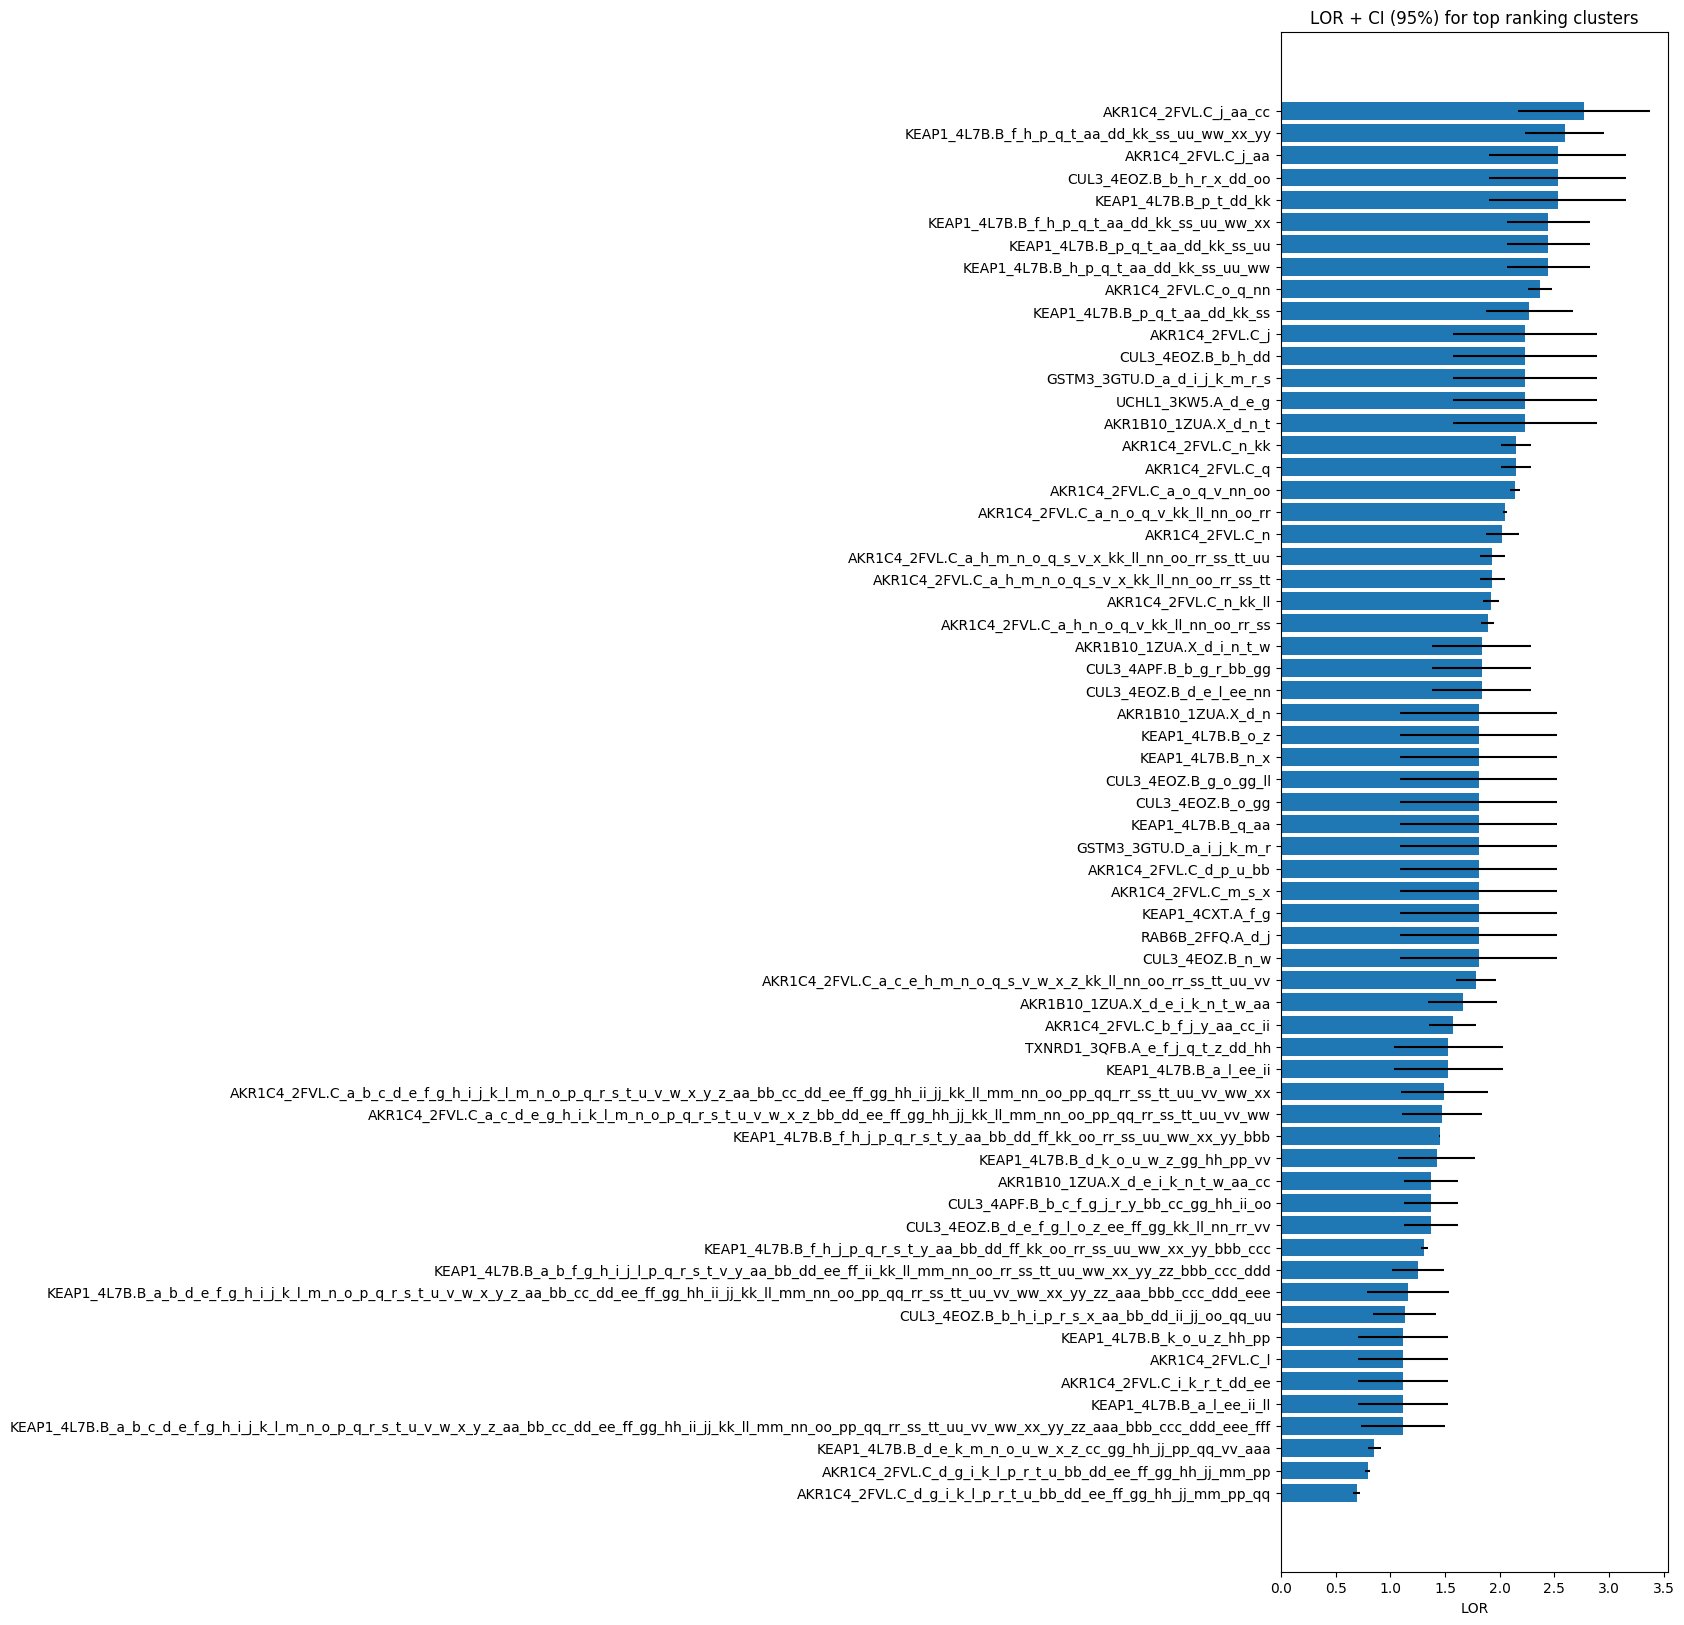

In [19]:
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(5,20))

ll = qq.sort_values('LOR',ascending=False)

# Example data
people = ll.feature.tolist()
y_pos = np.arange(len(people))
performance = ll.LOR.tolist()
error = ll.LogCI_95.tolist()

ax.barh(y_pos, performance, xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('LOR')
ax.set_title('LOR + CI (95%) for top ranking clusters')

plt.savefig('/home/ebc/Desktop/LOR_plot.png')
plt.show()


In [20]:
FT_sub = FT[(FT.OR>1)&(FT.OR<100)]
FT_sub = FT_sub.loc[FT_sub.CI_95<FT_sub.OR*.5]
FT_sub.sort_values(['OR','% samples'], ascending=False, inplace=True)
FT_sub

,feature,IC,FDR,% samples,OR,LOR,CI_95,LogCI_95,number_samples,number_variants,Desc
26,AKR1C4_2FVL.C_j_aa_cc,0.18995,0.142308,0.017595,15.983607,2.77156,1.82802,0.603233,6,3,
13,KEAP1_4L7B.B_f_h_p_q_t_aa_dd_kk_ss_uu_ww_xx_yy,0.272017,0.0047619,0.029326,13.379310,2.59371,1.44014,0.364743,10,8,
21,KEAP1_4L7B.B_p_t_dd_kk,0.218559,0.0047619,0.014663,12.580645,2.53216,1.86972,0.625791,5,4,
37,AKR1C4_2FVL.C_j_aa,0.167435,0.326316,0.014663,12.580645,2.53216,1.86972,0.625791,5,2,
46,CUL3_4EOZ.B_b_h_r_x_dd_oo,0.155286,0.414894,0.014663,12.580645,2.53216,1.86972,0.625791,5,6,
15,KEAP1_4L7B.B_h_p_q_t_aa_dd_kk_ss_uu_ww,0.257836,0.0047619,0.026393,11.508475,2.44308,1.46054,0.378804,9,7,
16,KEAP1_4L7B.B_p_q_t_aa_dd_kk_ss_uu,0.257836,0.0047619,0.026393,11.508475,2.44308,1.46054,0.378804,9,7,
17,KEAP1_4L7B.B_f_h_p_q_t_aa_dd_kk_ss_uu_ww_xx,0.257836,0.0047619,0.026393,11.508475,2.44308,1.46054,0.378804,9,7,
1,AKR1C4_2FVL.C_o_q_nn,0.324241,0.0047619,0.046921,10.666667,2.36712,1.11869,0.112156,16,2,
18,KEAP1_4L7B.B_p_q_t_aa_dd_kk_ss,0.247435,0.0047619,0.023460,9.700000,2.27213,1.48691,0.396701,8,6,


## Add probabilities, ROC, AUC, etc to Feature table

##### TO do: Look at https://www.quora.com/How-can-Should-I-create-a-Naive-Bayes-model-with-different-feature-distributions
##### and : https://www.quora.com/What-is-the-best-way-to-use-continuous-variables-for-a-naive-bayes-classifier-Do-we-need-to-cluster-them-or-leave-for-self-learning-Pls-help

#### code to compute p-value and AUC/ ROC

In [23]:
from itertools import combinations 
#from tqdm import tqdm
from IPython.display import clear_output

def compute_ROC(s, models, probabilities, cluster_inds):
        
    model_roc = {model: {} for model in models}

    for model, p_R1_v, vs in zip(
        models,
        probabilities,
        cluster_inds,):

        p_R1_vv = np.full(s.size, np.nan)

        for i in range(s.size):

            coordinate = [
                [np.argmin(abs(np.linspace(v.min(), v.max(), grid_size) - v[i]))]
                for v in vs
            ]

            p_R1_vv[i] = p_R1_v[coordinate]

        fpr, tpr, t = roc_curve(s, ccal.normalize_nd_array(p_R1_vv, None, "0-1"))

        model_roc[model]["fpr"] = fpr

        model_roc[model]["tpr"] = tpr

        auc_ = auc(fpr, tpr)

        model_roc[model]["auc"] = auc_

        n_permutation_for_roc = 1000

        permuting_aucs = np.full(n_permutation_for_roc, np.nan)

        permuting_s = s.copy()

        for i in range(n_permutation_for_roc):

            np.random.shuffle(permuting_s)

            permuting_fpr, permuting_tpr, permuting_t = roc_curve(permuting_s, p_R1_vv)

            permuting_aucs[i] = auc(permuting_fpr, permuting_tpr)

        model_roc[model]["p-value"] = ccal.compute_empirical_p_value(auc_, permuting_aucs, ">")

    for model in model_roc.keys():
        print(model,"\tp-val:",model_roc[model]["p-value"], "\tAUC:", model_roc[model]['auc'])
    
    return model_roc

In [24]:
read_to_struct = []

grid_size = 16

c = 0
for i in FT_sub.index[0:10]:
    
    f = FT_sub['feature'].ix[i]
    
    if 'response' in f:
        read_to_struct.append({'p_val':'','AUC':'','gene':'','structureChainId':'','model_name':model_name,'cluster_index':'','cluster_ID':'','p_R_C':'','p_R1_C':'','FPR':'','TPR':''})
    else:
    
        tmp = []

        cluster = f.split('.')[1][2:]
        gene = f.split('_')[0]
        structureChainId = f.split('_')[1]
        model_name = "P(R = 1 | C%s)"%str(c)

        # compute posterior probability, kernal density estimation, singular (one cluster only)
        p_R_C1, p_R1_C1 = ccal.infer((cluster_components.loc[f], binary_RNA), grid_size=grid_size, target="max", names=(i, 'NRF2v2'))

        # nomogram paper - we need to implement confidence intervals

        # compute significance and AUC
        A = (model_name,)
        B = (p_R1_C1,)
        C = ((cluster_components.loc[list_clusters[c]],),)

        model_roc = compute_ROC(binary_RNA, A, B, C)


        read_to_struct.append({'p_val':model_roc[model_name]["p-value"],'AUC':model_roc[model_name]["auc"],'gene':gene,'structureChainId':structureChainId,'model_name':model_name,'cluster_index':c,'feature':f,'p_R_C':[p_R_C1],'p_R1_C':[p_R1_C1],'FPR':[model_roc[model_name]["fpr"]],'TPR':[model_roc[model_name]["tpr"]]}) 

        c += 1
        
    clear_output(wait=True)

#FT_sub = pd.concat([FT_sub,pd.DataFrame(read_to_struct)],1)


Infering ...
	Computing P(variables)...


	Computing P(target variable | non-target variables) ...


	Getting target grid coordinates ...
	Computing P(target variable = target | non-target variables) ...


P(R = 1 | C9) 	p-val: 1.0 	AUC: 0.42466371761307214


In [25]:
tt = pd.DataFrame(read_to_struct)
tt = tt[['feature','AUC','p_val','gene','structureChainId','model_name','p_R1_C','p_R_C','cluster_index','FPR','TPR']]
tt
#tt.to_csv('/home/ebc/Desktop/model_Stats.csv')

,feature,AUC,p_val,gene,structureChainId,model_name,p_R1_C,p_R_C,cluster_index,FPR,TPR
0,AKR1C4_2FVL.C_j_aa_cc,0.591812,0.002,AKR1C4,2FVL.C,P(R = 1 | C0),"[[0.22171684277187126, 0.22171684277187123, 0....","[[[0.22171684277187126, 0.20499298432823607, 0...",0,"[[0.0, 0.023923444976076555, 1.0]]","[[0.0, 0.20754716981132076, 1.0]]"
1,KEAP1_4L7B.B_f_h_p_q_t_aa_dd_kk_ss_uu_ww_xx_yy,0.415230,1.000,KEAP1,4L7B.B,P(R = 1 | C1),"[[0.22415329152845237, 0.2241532915284524, 0.2...","[[[0.22415329152845237, 0.20724565385294075, 0...",1,"[[0.0, 0.9808612440191388, 1.0]]","[[0.0, 0.8113207547169812, 1.0]]"
2,KEAP1_4L7B.B_p_t_dd_kk,0.368737,1.000,KEAP1,4L7B.B,P(R = 1 | C2),"[[0.2208541313444437, 0.22085413134444368, 0.2...","[[[0.2208541313444437, 0.2041953464809671, 0.1...",2,"[[0.0, 0.8851674641148325, 1.0]]","[[0.0, 0.6226415094339622, 1.0]]"
3,AKR1C4_2FVL.C_j_aa,0.410580,1.000,AKR1C4,2FVL.C,P(R = 1 | C3),"[[0.22085413134444368, 0.22085413134444368, 0....","[[[0.22085413134444368, 0.2041953464809671, 0....",3,"[[0.0, 0.9712918660287081, 1.0]]","[[0.0, 0.7924528301886793, 1.0]]"
4,CUL3_4EOZ.B_b_h_r_x_dd_oo,0.427056,1.000,CUL3,4EOZ.B,P(R = 1 | C4),"[[0.21873053398462203, 0.21873053398462203, 0....","[[[0.21873053398462203, 0.2022319302415358, 0....",4,"[[0.0, 0.9760765550239234, 1.0]]","[[0.0, 0.8301886792452831, 1.0]]"
5,KEAP1_4L7B.B_h_p_q_t_aa_dd_kk_ss_uu_ww,0.382820,1.000,KEAP1,4L7B.B,P(R = 1 | C5),"[[0.22326731016242288, 0.2232673101624229, 0.2...","[[[0.22326731016242288, 0.20642650129850265, 0...",5,"[[0.0, 0.8947368421052632, 1.0]]","[[0.0, 0.660377358490566, 1.0]]"
6,KEAP1_4L7B.B_p_q_t_aa_dd_kk_ss_uu,0.415365,1.000,KEAP1,4L7B.B,P(R = 1 | C6),"[[0.22326731016242288, 0.2232673101624229, 0.2...","[[[0.22326731016242288, 0.20642650129850265, 0...",6,"[[0.0, 0.9617224880382775, 1.0]]","[[0.0, 0.7924528301886793, 1.0]]"
7,KEAP1_4L7B.B_f_h_p_q_t_aa_dd_kk_ss_uu_ww_xx,0.413108,1.000,KEAP1,4L7B.B,P(R = 1 | C7),"[[0.22326731016242288, 0.2232673101624229, 0.2...","[[[0.22326731016242288, 0.20642650129850265, 0...",7,"[[0.0, 0.9473684210526315, 1.0]]","[[0.0, 0.7735849056603774, 1.0]]"
8,AKR1C4_2FVL.C_o_q_nn,0.413108,1.000,AKR1C4,2FVL.C,P(R = 1 | C8),"[[0.2262926123878895, 0.22629261238788947, 0.2...","[[[0.2262926123878895, 0.20922360758194972, 0....",8,"[[0.0, 0.9473684210526315, 1.0]]","[[0.0, 0.7735849056603774, 1.0]]"
9,KEAP1_4L7B.B_p_q_t_aa_dd_kk_ss,0.424664,1.000,KEAP1,4L7B.B,P(R = 1 | C9),"[[0.22238830502762197, 0.22238830502762197, 0....","[[[0.22238830502762197, 0.20561379876417837, 0...",9,"[[0.0, 0.9808612440191388, 1.0]]","[[0.0, 0.8301886792452831, 1.0]]"


In [26]:
ttt = pd.merge(FT_sub,tt,on='feature')
ttt.head()

,feature,IC,FDR,% samples,OR,LOR,CI_95,LogCI_95,number_samples,number_variants,Desc,AUC,p_val,gene,structureChainId,model_name,p_R1_C,p_R_C,cluster_index,FPR,TPR
0,AKR1C4_2FVL.C_j_aa_cc,0.18995,0.142308,0.017595,15.983607,2.77156,1.82802,0.603233,6,3,,0.591812,0.002,AKR1C4,2FVL.C,P(R = 1 | C0),"[[0.22171684277187126, 0.22171684277187123, 0....","[[[0.22171684277187126, 0.20499298432823607, 0...",0,"[[0.0, 0.023923444976076555, 1.0]]","[[0.0, 0.20754716981132076, 1.0]]"
1,KEAP1_4L7B.B_f_h_p_q_t_aa_dd_kk_ss_uu_ww_xx_yy,0.272017,0.0047619,0.029326,13.379310,2.59371,1.44014,0.364743,10,8,,0.415230,1.000,KEAP1,4L7B.B,P(R = 1 | C1),"[[0.22415329152845237, 0.2241532915284524, 0.2...","[[[0.22415329152845237, 0.20724565385294075, 0...",1,"[[0.0, 0.9808612440191388, 1.0]]","[[0.0, 0.8113207547169812, 1.0]]"
2,KEAP1_4L7B.B_p_t_dd_kk,0.218559,0.0047619,0.014663,12.580645,2.53216,1.86972,0.625791,5,4,,0.368737,1.000,KEAP1,4L7B.B,P(R = 1 | C2),"[[0.2208541313444437, 0.22085413134444368, 0.2...","[[[0.2208541313444437, 0.2041953464809671, 0.1...",2,"[[0.0, 0.8851674641148325, 1.0]]","[[0.0, 0.6226415094339622, 1.0]]"
3,AKR1C4_2FVL.C_j_aa,0.167435,0.326316,0.014663,12.580645,2.53216,1.86972,0.625791,5,2,,0.410580,1.000,AKR1C4,2FVL.C,P(R = 1 | C3),"[[0.22085413134444368, 0.22085413134444368, 0....","[[[0.22085413134444368, 0.2041953464809671, 0....",3,"[[0.0, 0.9712918660287081, 1.0]]","[[0.0, 0.7924528301886793, 1.0]]"
4,CUL3_4EOZ.B_b_h_r_x_dd_oo,0.155286,0.414894,0.014663,12.580645,2.53216,1.86972,0.625791,5,6,,0.427056,1.000,CUL3,4EOZ.B,P(R = 1 | C4),"[[0.21873053398462203, 0.21873053398462203, 0....","[[[0.21873053398462203, 0.2022319302415358, 0....",4,"[[0.0, 0.9760765550239234, 1.0]]","[[0.0, 0.8301886792452831, 1.0]]"


In [27]:
# all data across all clusters (took 59 hours)
Cluster_Models = pd.read_csv('/home/ebc/Desktop/Ct2_Adv_Lin_Reg/model_Stats_full.csv', index_col=0)
Cluster_Models.head()

,feature,IC,FDR,% samples,OR,LOR,CI_95,LogCI_95,number_samples,number_variants,Desc,AUC,p_val,gene,structureChainId,model_name,p_R1_C,p_R_C,cluster_index,FPR,TPR
0,AKR1C4_2FVL.C_j_aa_cc,0.189950,0.142308,0.017595,15.983607,2.771564,1.828019,0.603233,6,3,NaN,0.591812,0.001,AKR1C4,2FVL.C,P(R = 1 | C0),"[array([0.22171684, 0.22171684, 0.22171684, 0....","[array([[0.22171684, 0.20499298, 0.16201682, 0...",0,"[array([0. , 0.02392344, 1. ])]","[array([0. , 0.20754717, 1. ])]"
1,KEAP1_4L7B.B_f_h_p_q_t_aa_dd_kk_ss_uu_ww_xx_yy,0.272017,0.004762,0.029326,13.379310,2.593710,1.440143,0.364743,10,8,NaN,0.415230,1.000,KEAP1,4L7B.B,P(R = 1 | C1),"[array([0.22415329, 0.22415329, 0.22415329, 0....","[array([[0.22415329, 0.20724565, 0.16379721, 0...",1,"[array([0. , 0.98086124, 1. ])]","[array([0. , 0.81132075, 1. ])]"
2,KEAP1_4L7B.B_p_t_dd_kk,0.218559,0.004762,0.014663,12.580645,2.532160,1.869725,0.625791,5,4,NaN,0.368737,1.000,KEAP1,4L7B.B,P(R = 1 | C2),"[array([0.22085413, 0.22085413, 0.22085413, 0....","[array([[0.22085413, 0.20419535, 0.1613864 , 0...",2,"[array([0. , 0.88516746, 1. ])]","[array([0. , 0.62264151, 1. ])]"
3,AKR1C4_2FVL.C_j_aa,0.167435,0.326316,0.014663,12.580645,2.532160,1.869725,0.625791,5,2,NaN,0.410580,1.000,AKR1C4,2FVL.C,P(R = 1 | C3),"[array([0.22085413, 0.22085413, 0.22085413, 0....","[array([[0.22085413, 0.20419535, 0.1613864 , 0...",3,"[array([0. , 0.97129187, 1. ])]","[array([0. , 0.79245283, 1. ])]"
4,CUL3_4EOZ.B_b_h_r_x_dd_oo,0.155286,0.414894,0.014663,12.580645,2.532160,1.869725,0.625791,5,6,NaN,0.427056,1.000,CUL3,4EOZ.B,P(R = 1 | C4),"[array([0.21873053, 0.21873053, 0.21873053, 0....","[array([[0.21873053, 0.20223193, 0.15983461, 0...",4,"[array([0. , 0.97607656, 1. ])]","[array([0. , 0.83018868, 1. ])]"
